## Diamonds Price 
---
This is a [dataset](https://www.kaggle.com/shivam2503/diamonds) of diamonds features with price, we'll try to predict the price from the features.

In [110]:
#import needed library 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [111]:
# load dataset and set id col as index 
df = pd.read_csv('diamonds.csv', index_col=0)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [112]:
# Column names 
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [113]:
df.agg(['nunique'])

,carat,cut,color,clarity,depth,table,price,x,y,z
nunique,273,5,7,8,184,127,11602,554,552,375


So What We Have? 
#### diamonds features
    - carat: weight of the diamond, (min:0.2 - max:5.01), Quantitative, continuous
    - cut: quality of the cut, (Fair, Good, Very Good, Premium, Ideal),  Categorical
    - color: diamond colour, from J (worst) to D (best), Categorical
    - clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)), Categorical
    - x length: in mm (0 - 10.74), Quantitative, continuous
    - y width: in mm (0 - 58.9), Quantitative, continuous
    - z depth: in mm (0 - 31.8), Quantitative, continuous
    - depth: The Height of a Diamond, measured from the Culet to the table, divided by its average Girdle Diameter,  (43 - 79), Quantitative, continuous
        -  depth = z / mean(x, y) = 2 * z / (x + y)
    - table: width of top of diamond relative to widest point (43 - 95), Quantitative, continuous
    - price: price in US dollars ($326 - $18,823), Quantitative, continuous

### Frame
First let's define the problem we'll solve with this dataset, This notebook should answer customers questions as well as gives them a good predicting tool, so what we'll do:
- mainly we'll predict the diamond price from diamond feature 
    - to do this we'll use different regression algorithms
    - and evaluation techniques
- As we go we'll do a lot analysis and answer many question such as 
    - What the most important feature on a diamond that effect the price
    - For the categorical features is there a pattern?, so when you choose the best the salary should be high or vice versa
    - According to this data, what's the probability that if you bought a diamond it'll be on the Fair cut, worst clarity, what's the probability that you get the bad diamond with worst cut, clarity, and color? 

### Prepare 
First we'll look at our null values, and how we can deal with it

In [114]:
# is there missing data? 
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

let see if we have negative or zero values * as we consider them as missing value *.

In [115]:
df[df.carat <= 0].shape, df[df.depth <= 0].shape, df[df.table <= 0].shape, df[df.price <= 0].shape

((0, 10), (0, 10), (0, 10), (0, 10))

In [116]:
# we'll check if we have a diamond with 0 in x, y ,or z 
df[(df.x == 0) | (df.y == 0) | (df.z == 0)].shape 

(20, 10)

As we can see we have 20 rows with missing value, let's drop them

In [117]:
df = df[(df.x != 0) & (df.y != 0) & (df.z != 0)]
df.shape

(53920, 10)

In [118]:
# info function gives you more information about your date, we'll use it instead of dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53920 entries, 1 to 53940
Data columns (total 10 columns):
carat      53920 non-null float64
cut        53920 non-null object
color      53920 non-null object
clarity    53920 non-null object
depth      53920 non-null float64
table      53920 non-null float64
price      53920 non-null int64
x          53920 non-null float64
y          53920 non-null float64
z          53920 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [119]:
# then great to have summary of this data 
# get_dtype_counts Gives you a count of each type in the dataframe
df.get_dtype_counts()

float64    6
int64      1
object     3
dtype: int64

In [120]:
# The row index
df.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            53931, 53932, 53933, 53934, 53935, 53936, 53937, 53938, 53939,
            53940],
           dtype='int64', length=53920)

How great is that?, now let's move on to convert our categorical columns from strings to integer, this is will help a lot when we try to build our model.

In [121]:
# we'll follow that approach the lowest value the worest, and the highest the best 
rename_cols = { "cut" : {"Fair": 1, "Good": 2, "Very Good": 3, "Premium": 4, "Ideal": 5}, \
                "color":{"J": 1, "I": 2,"H": 3, "G": 4, "F": 5, "E": 6, "D": 7}, \
                "clarity":{"I1": 1 , "SI2": 2, "SI1": 3, "VS2": 4, "VS1": 5, "VVS2": 6, "VVS1": 7, "IF": 8 }  
               }

In [122]:
transformed_df = df.copy()
transformed_df.replace(rename_cols, inplace=True)
transformed_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,5,6,2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,4,6,3,59.8,61.0,326,3.89,3.84,2.31
3,0.23,2,6,5,56.9,65.0,327,4.05,4.07,2.31
4,0.29,4,2,4,62.4,58.0,334,4.20,4.23,2.63
5,0.31,2,1,2,63.3,58.0,335,4.34,4.35,2.75


### Analyze 

let's start this part with finding main descriptive statistics

In [123]:
# Describe numeric columns.
df.describe()

,carat,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797698,61.749514,57.456834,3930.993231,5.731627,5.734887,3.540046
std,0.473795,1.432331,2.234064,3987.280446,1.119423,1.140126,0.702530
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5323.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [124]:
# Describe object columns
df.describe(include=['object'])

,cut,color,clarity
count,53920,53920,53920
unique,5,7,8
top,Ideal,G,SI1
freq,21548,11284,13063


Well, `describe` method gives us a lot of values but this table is hard to read and find insight from it, so let's try to visualize these columns 

/Users/abdulazizalawshan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


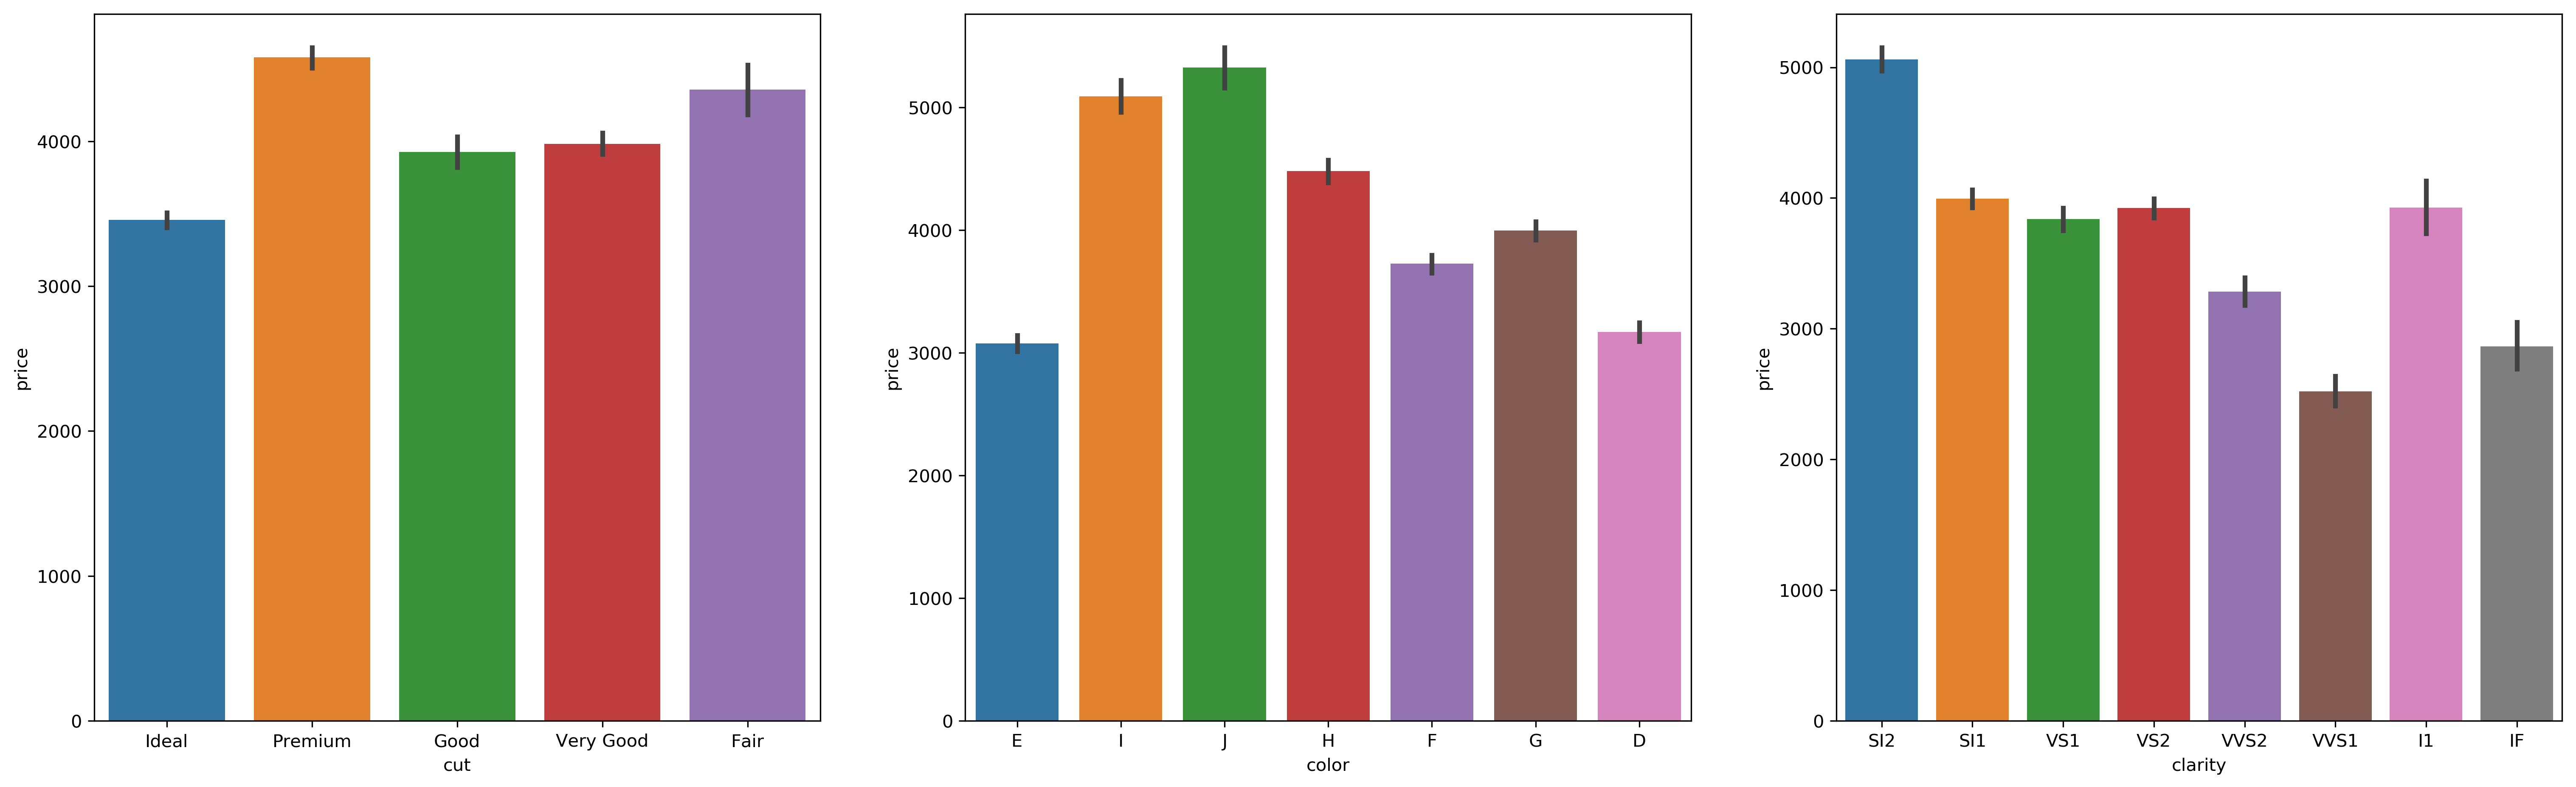

In [125]:
categorical_cols = ["cut","color","clarity"]
price = "price"
fig2 = plt.figure(figsize=(25,25), dpi=300)

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(3,3,idx+1)
    ax = sns.barplot(x=col, y="price", data=df)
    ax.set_ylabel(price)
    ax.set_xlabel(col)
    
#for this warning https://github.com/scipy/scipy/pull/8944/commits/1955c60c08337c6d2bafcd2c2a94cc44feac8ecc

it's pretty clear that there is no linear correlation between cut and clarity with price, and it looks like there is a weird correlation between color and price, weird because bad color has the highest price, it's clear that this is customer preferences, it's not clear to you? I'll modify this graph and take another look

/Users/abdulazizalawshan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


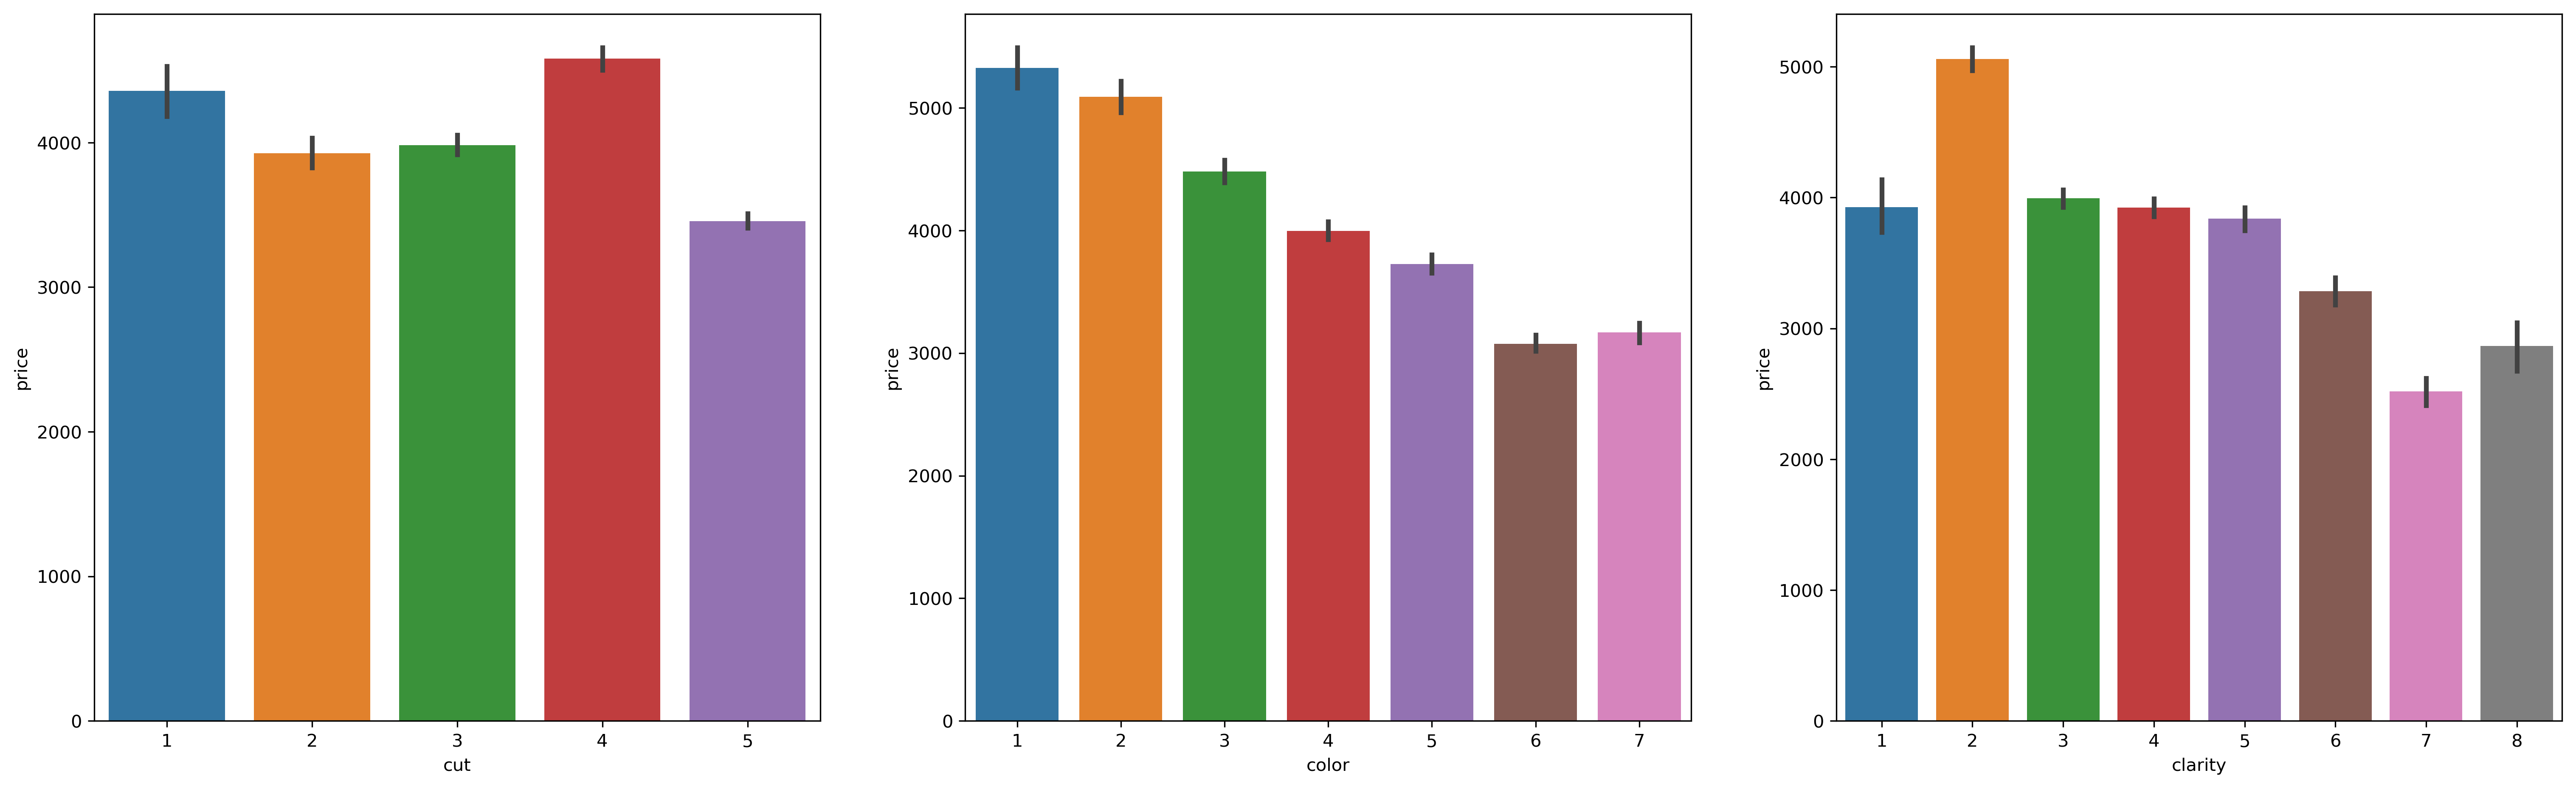

In [126]:
categorical_cols = ["cut","color","clarity"]
price = "price"
fig2 = plt.figure(figsize=(25,25), dpi=300)

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(3,3,idx+1)
    ax = sns.barplot(x=col, y="price", data=transformed_df)
    ax.set_ylabel(price)
    ax.set_xlabel(col)
#for this warning https://github.com/scipy/scipy/pull/8944/commits/1955c60c08337c6d2bafcd2c2a94cc44feac8ecc

Now it's more clear, after I replace each object with value and as we said above the lowest value the worest, and the highest the best, so best cut or clarity has highest value, worest cut or color has lowest value, and we'll keep useing it as I find it easer for who read this notebook to keep track with each category.

after this change we can notice what we wrote on abvoe cell **there is no linear correlation between cut and clarity with price, and it looks like there is a weird correlation between color and price, weird because bad color has the highest price, it's clear that this is customer preferences**

we'll keep investegate these three columns, we'll try to see the most selling diamons type for each column, these can show you side of customer preferences, and this side can effect the price, so let see

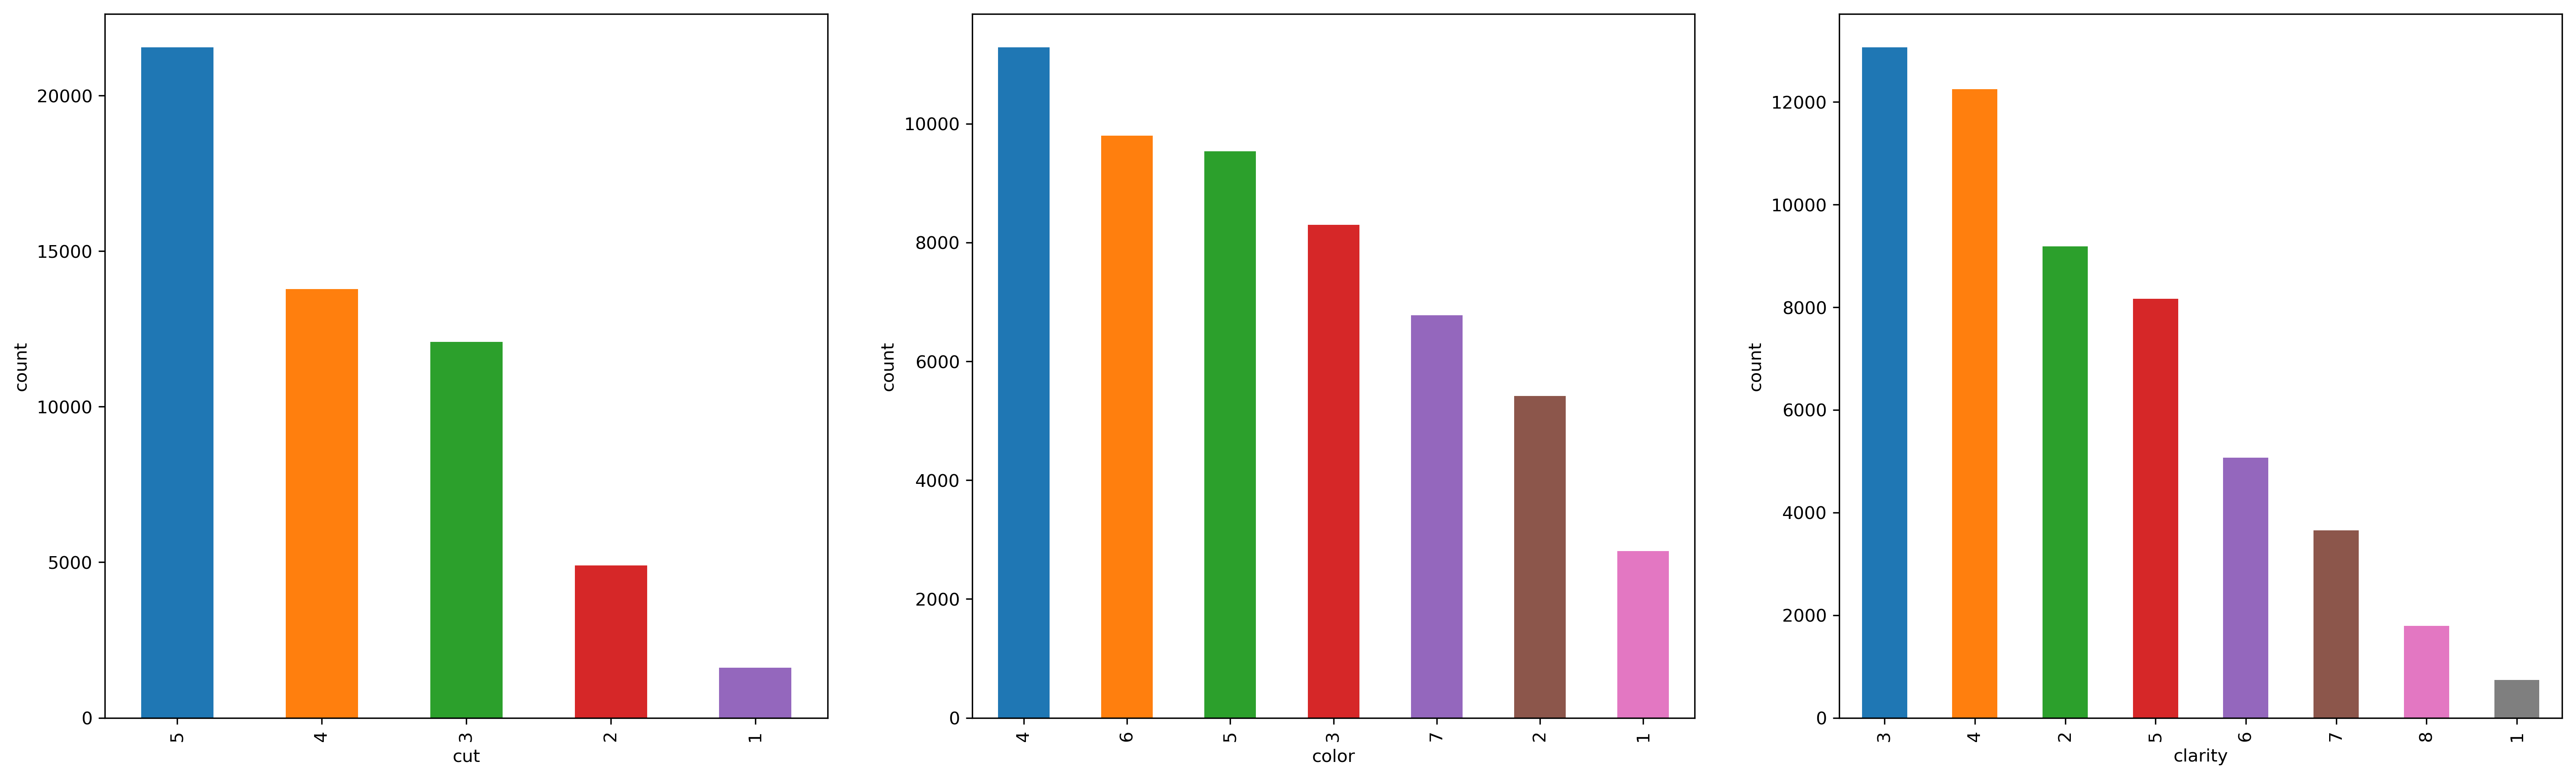

In [127]:
fig2 = plt.figure(figsize=(25,25), dpi=300)

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(3,3,idx+1)
    ax = transformed_df[col].value_counts().plot(kind='bar')
    ax.set_ylabel("count")
    ax.set_xlabel(col)

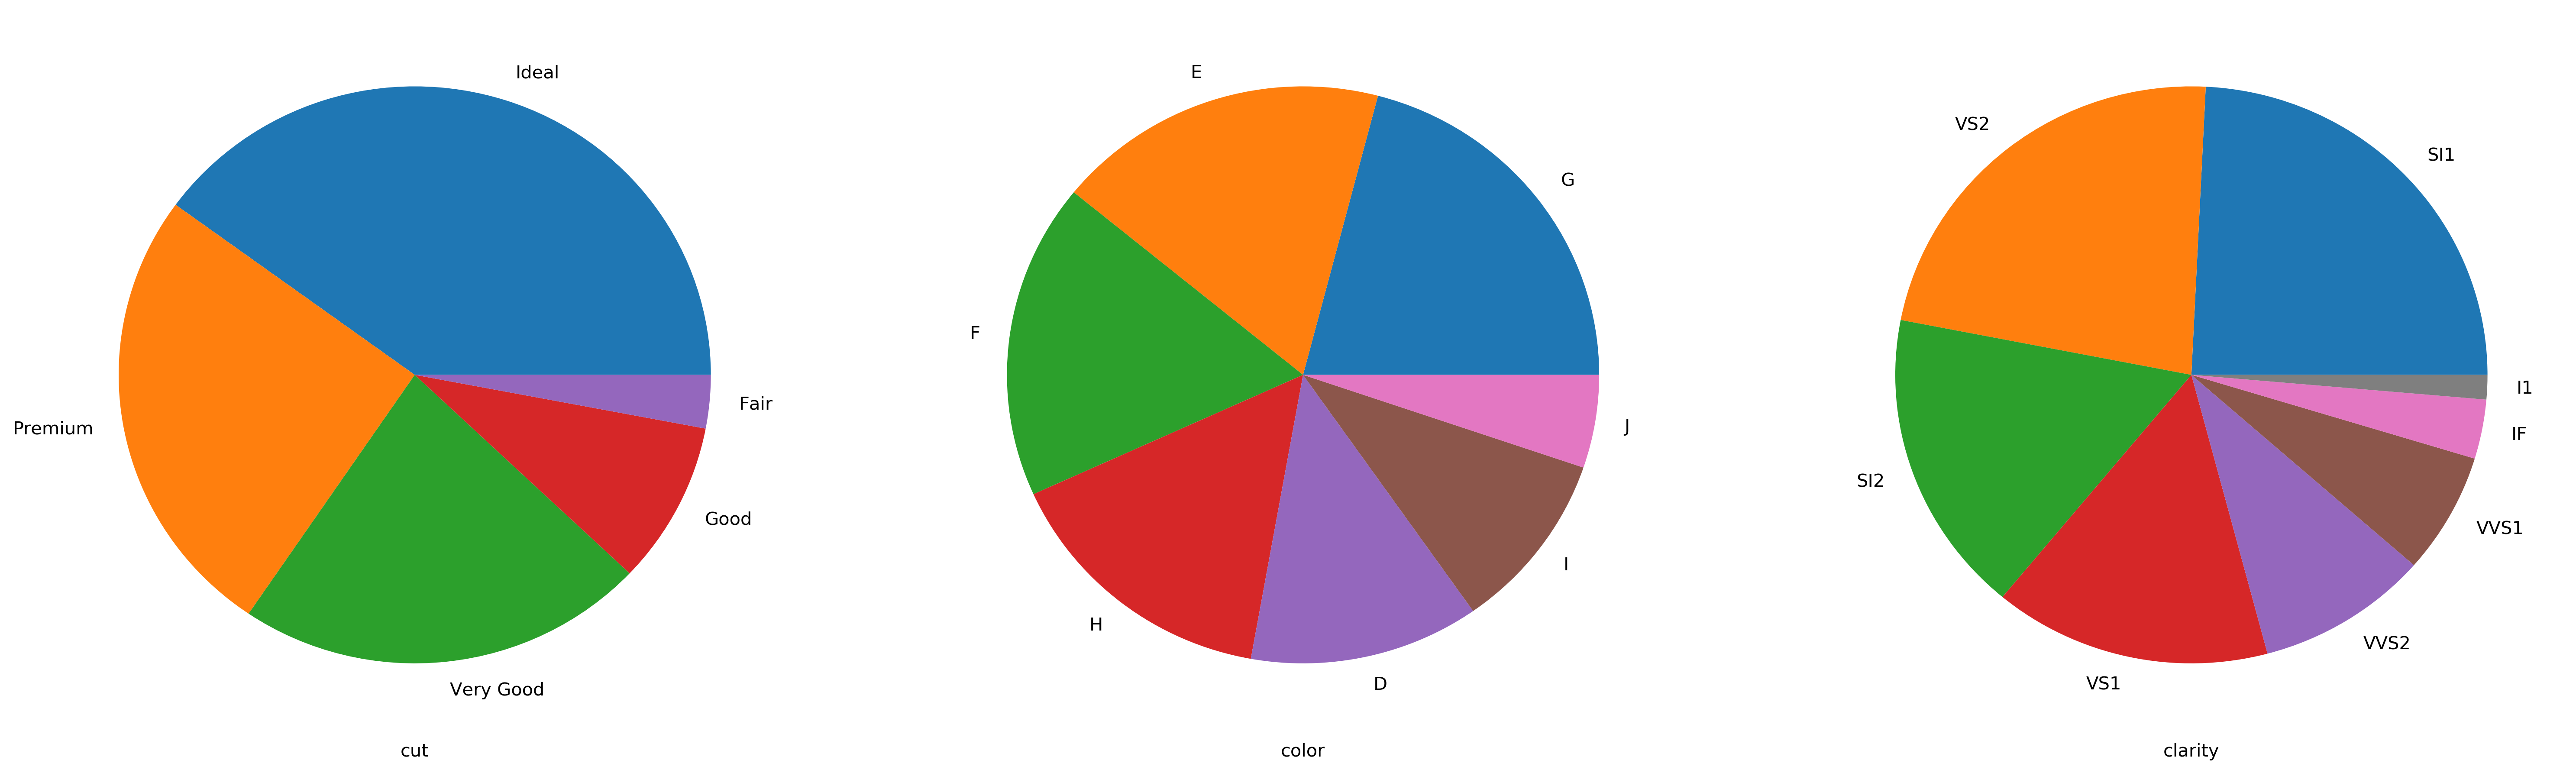

In [128]:
#or we can do this 
fig2 = plt.figure(figsize=(25,25), dpi=300)

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(3,3,idx+1)
    df[col].value_counts(normalize=True).mul(100).plot(kind='pie')
    ax.set_ylabel("")
    ax.set_xlabel(col)

sounds good, we visualized object columns(categorical), now let visualize numeric columns 

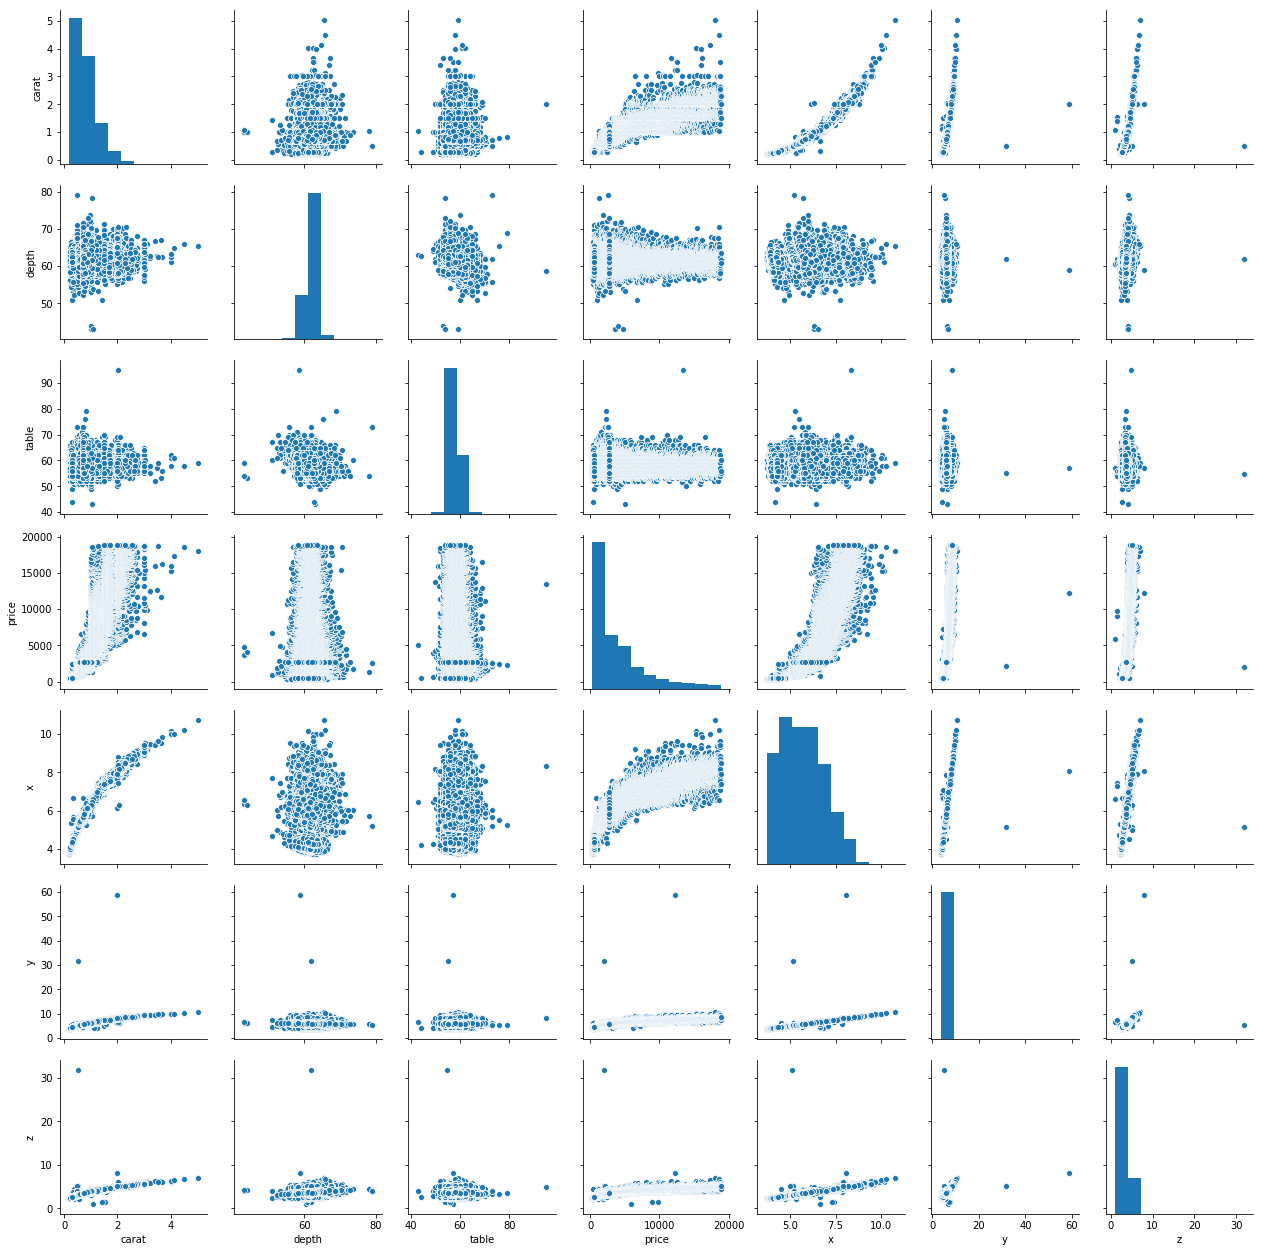

In [129]:
numrical_col = ["carat","cut","color","clarity","depth","table","price","x","y","z"]
sns.pairplot(df[numrical_col])

If we take a look on price and x,y,z, and cart, we can see linear line increasing, put price and depth, table, we can see that the is distributed on the graph.

Now let's check correlation and visualize it with `heatmap` and `plots`, and keep in your mind this method works only with numeric columns

In [130]:
corr = df.corr()
corr

,carat,depth,table,price,x,y,z
carat,1.000000,0.028259,0.181646,0.921592,0.977779,0.953991,0.961048
depth,0.028259,1.000000,-0.295733,-0.010729,-0.025017,-0.029069,0.095023
table,0.181646,-0.295733,1.000000,0.127245,0.196097,0.184493,0.152483
price,0.921592,-0.010729,0.127245,1.000000,0.887231,0.867864,0.868206
x,0.977779,-0.025017,0.196097,0.887231,1.000000,0.974918,0.975435
y,0.953991,-0.029069,0.184493,0.867864,0.974918,1.000000,0.956744
z,0.961048,0.095023,0.152483,0.868206,0.975435,0.956744,1.000000


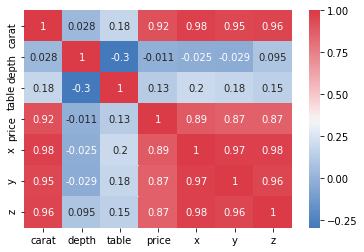

In [131]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(250, 10, as_cmap=True), annot=True)

We can see that there is a high correlation between price and x,y,z, and cart, on other side there is a low correlation between price and depth, table, also as we don't see the categorical variable here we'll use boxplot to find more insight from this columns

This is a nice chart to show the linear correlation between those columns we mentioned above

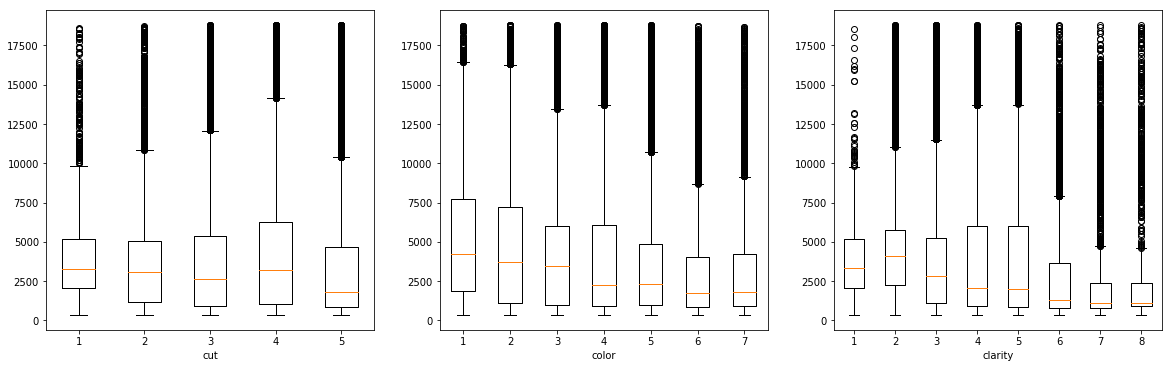

In [132]:
cut = ["Fair", "Good", "Very Good","Premium","Ideal"]
color = ["J", "I","H", "G", "F", "E", "D"]
clarity = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
categorical_columns = [("cut" ,cut),("color" ,color),("clarity" ,clarity)]

plt.figure(figsize=(20,20))

for idx, categories in enumerate(categorical_columns):
    ax = plt.subplot(3,3,idx+1)
    ax.set_xlabel(categories[0])
    box = [df[df[categories[0]] == atype].price for atype in categories[1]]
    ax.boxplot(box)

Understanding Box Plot :
- The bottom line indicates the min value.
- The upper line indicates the max value.
- The middle line of the box is the median or the 50% percentile.
- The side lines of the box are the 25 and 75 percentiles respectively.

This box chart show that there are a huge outlier on clarity also you can see that the clarity 4 (VS2) and 5 (VS1) have almost same and higher price on clarity, This chart also shows how is bad color has higher price over the good color, and you can see on cut chart that the 5 (Ideal) cut has the lower price, we can say that the cut it's not correlated linearly to price 

now let's take a look on out target variable.

/Users/abdulazizalawshan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


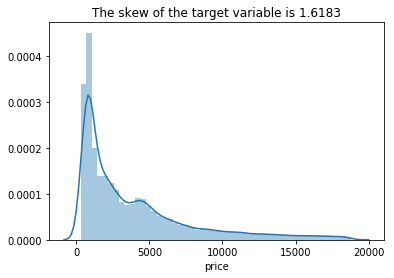

In [133]:
sns.distplot(df["price"])
#sns.distplot(df["price"])
plt.title('The skew of the target variable is {:.4f}'.format(df.price.skew()));

As we can see there is a high right skew on our target variable, we'll fix that later, and we'll check correlated variables skewness and try fix them 

### Feature Engineering

Now we will make two modification to the dataset we'll compin x,y, and z as shape, So Shape = x * y * z,  
also cut, color, and clarity as quality we gave each categorical variable a number from 1 to n, so we'll compute the summation as quality

In [134]:
transformed_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,5,6,2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,4,6,3,59.8,61.0,326,3.89,3.84,2.31
3,0.23,2,6,5,56.9,65.0,327,4.05,4.07,2.31
4,0.29,4,2,4,62.4,58.0,334,4.20,4.23,2.63
5,0.31,2,1,2,63.3,58.0,335,4.34,4.35,2.75


In [135]:
transformed_df['shape'] = transformed_df.x * transformed_df.z * transformed_df.y
transformed_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,shape
1,0.23,5,6,2,61.5,55.0,326,3.95,3.98,2.43,38.202030
2,0.21,4,6,3,59.8,61.0,326,3.89,3.84,2.31,34.505856
3,0.23,2,6,5,56.9,65.0,327,4.05,4.07,2.31,38.076885
4,0.29,4,2,4,62.4,58.0,334,4.20,4.23,2.63,46.724580
5,0.31,2,1,2,63.3,58.0,335,4.34,4.35,2.75,51.917250


In [136]:
transformed_df['quality'] = transformed_df.cut + transformed_df.color + transformed_df.clarity 
transformed_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,shape,quality
1,0.23,5,6,2,61.5,55.0,326,3.95,3.98,2.43,38.202030,13
2,0.21,4,6,3,59.8,61.0,326,3.89,3.84,2.31,34.505856,13
3,0.23,2,6,5,56.9,65.0,327,4.05,4.07,2.31,38.076885,13
4,0.29,4,2,4,62.4,58.0,334,4.20,4.23,2.63,46.724580,10
5,0.31,2,1,2,63.3,58.0,335,4.34,4.35,2.75,51.917250,5


Now let's check correlation with heatmap again 

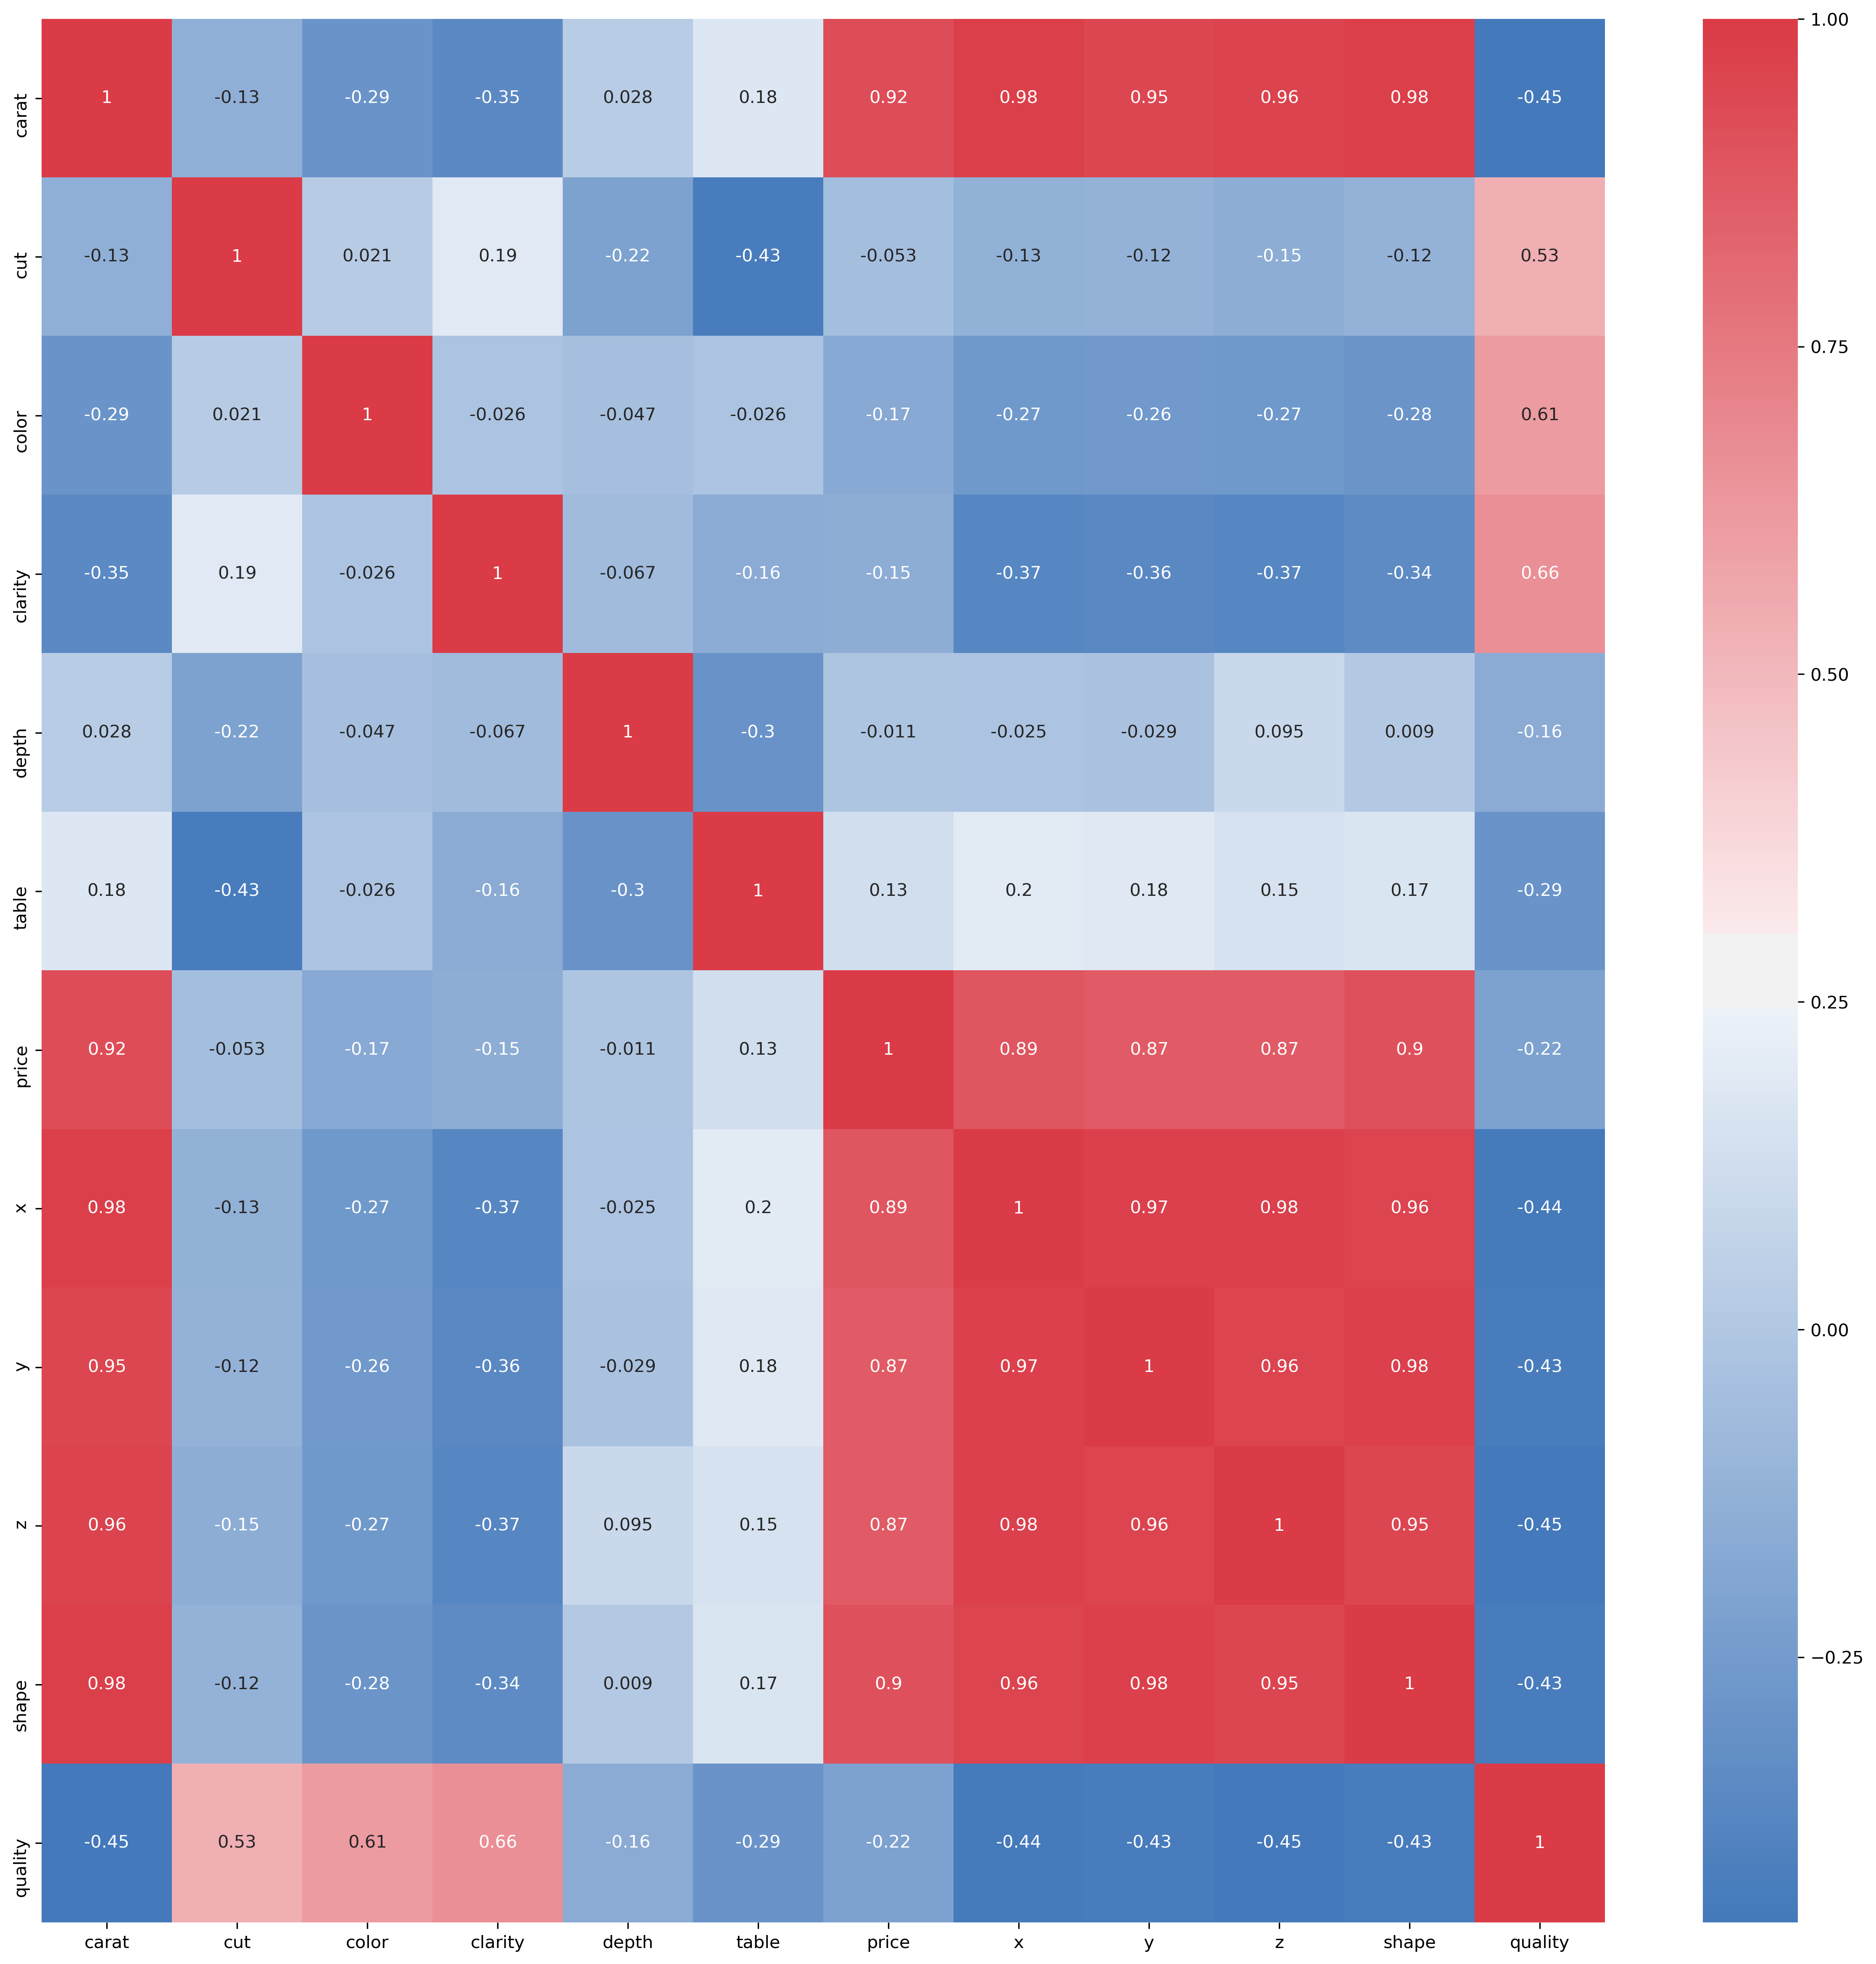

In [137]:
col = ["carat","cut","color","clarity","depth","table","price","x","y","z","shape","quality"]
corr = transformed_df[col].corr()
fig2 = plt.figure(figsize=(20,20), dpi=300)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(250, 10, as_cmap=True), annot=True)

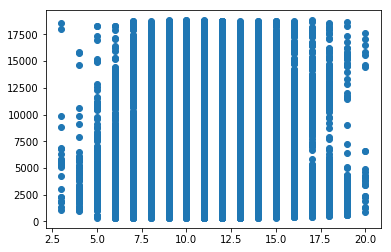

In [138]:
plt.scatter(transformed_df.quality, transformed_df.price)
plt.show()

Here we'll fix skewness problem

In [139]:
# log 

### Interpret

Now we'll do the most interesting part of this project, predict diamond price from diamond features, to do this we'll use regression algorithms.

What is regression in machine learning? 

is a supervised learning in machine learning. Given a training set of data containing observations and their associated continuous outputs, the goal of regression is to explore the relationships between the observations (also called features) and the targets, and to output a continuous value based on the input features of an unknown sample. *from Python Machine Learning By Example by By Yuxi Liu*

In [560]:
#import models that we'll use 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, RANSACRegressor

# train_test_split to split data to train and test the model 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# modelling algorithms that we'll use 

names = ['Linear Regression', 'All features Linear Regression', \
         'DecisionTree Regression', 'All features DecisionTree Regression', 'DecisionTree Regression with best features',\
         'RandomForest Regression', \
         'AdaBoost Regression with Linear Regression', 'AdaBoost Regression with DecisionTree', 'AdaBoost Regression with RandomForest',\
         'Random sample consensus']

R2_list = []

prepare variables and funcations that you need with all the models 

In [561]:
# evaluate the model with MAE, MSE, RMSE, and R2, then append R2 to list to compare it with all other models 
def evaluation_metrics(model_name,y_test, y_pred):    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    r2 = r2_score(y_test, y_pred)

    print(model_name)
    print('MAE  : %0.2f ' % mae)
    print('MSE  : %0.2f ' % mse)
    print('RMSE : %0.2f ' % rmse)
    print('R2   : %0.2f ' % r2)
    R2_list.append(r2)
    print('')

# visualize model predection vs true 
def visualize_model_predection(model_name, y_test, y_pred):
    plt.scatter(y_test, y_pred, alpha=0.5 , label='observed')
    plt.scatter(y_test, y_test, alpha=0.5, s = 3 ,label='predect')
    plt.hlines(y = 0, xmin=0, xmax=50)
    plt.title(model_name)
    plt.show()


ran_state = 42
    
# all the features
all_features = ['cut','color','clarity','depth','table', 'shape','carat']
all_X = transformed_df[all_features]

# selected features based on linear correlation heat map, any feature above .5 are included 
feature_cols = ['cut','shape','carat']
X = transformed_df[feature_cols]

y = transformed_df.price

In [562]:
# Check X's type.# Check 
print((type(X)))
print((type(X.values)))

print((type(all_X)))
print((type(all_X.values)))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [563]:
# Check y's type.# Check 
print((type(y)))
print((type(y.values)))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [564]:
# Check X's shape (n = number of observations, p = number of features).# Check 
print((X.shape))
print((all_X.shape))

(53920, 3)
(53920, 7)


In [565]:
# Check y's shape (single dimension with length n).
# The comma indicates the datatype is a tuple.
print((y.shape))

(53920,)


### Modeling with Linear Regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Index(['cut', 'shape', 'carat'], dtype='object')
Linear Regression
MAE  : 973.39 
MSE  : 2201541.10 
RMSE : 1483.76 
R2   : 0.86 



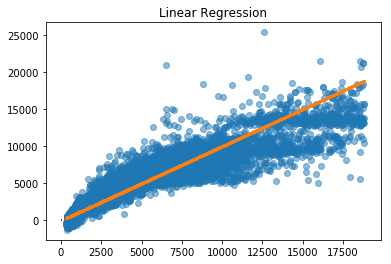

All features Linear Regression
MAE  : 836.79 
MSE  : 1416443.10 
RMSE : 1190.14 
R2   : 0.91 



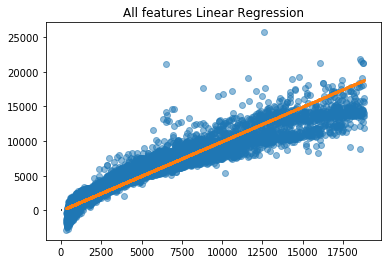

In [566]:
# Instantiate the estimator(model).
# Make an instance of a LinearRegression object.
linreg = LinearRegression()

# All parameters not specified are set to their defaults.
# Can specify tuning parameters (aka "hyperparameters") during this step.
# To view the possible parameters
# help(linreg) or just the instance name -> linreg 
print(linreg)

# split data to train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=ran_state)

#Fit the model with data (train model)
result = linreg.fit(X_train, y_train)
# Predict the response for a new observation.
y_pred = linreg.predict(X_test)
print(X_test.columns)
# evaluation the model 
evaluation_metrics(names[0], y_test, y_pred)

# visualize model predection
visualize_model_predection(names[0], y_test, y_pred)


'''
now we'll try it but with all feature not with high correlated only 
'''

# split data to train and test 
all_X_train, all_X_test, all_y_train, all_y_test = train_test_split(all_X, y, random_state=ran_state)

#Fit the model with data for all features (train model)
result = linreg.fit(all_X_train, all_y_train)
# Predict the response for a new observation.
y_pred = linreg.predict(all_X_test)

# evaluation the model with all features
evaluation_metrics((names[1]), all_y_test, y_pred)

# visualize model predection
visualize_model_predection(names[1], all_y_test, y_pred)

### Modeling with Decision Tree Regressor

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')
DecisionTree Regression
MAE  : 781.66 
MSE  : 1863837.60 
RMSE : 1365.22 
R2   : 0.88 



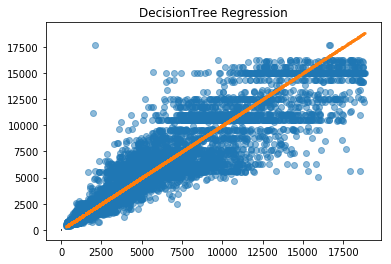

All features DecisionTree Regression
MAE  : 346.91 
MSE  : 424211.56 
RMSE : 651.32 
R2   : 0.97 



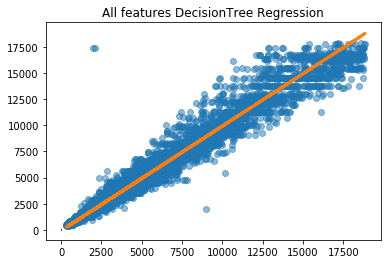

In [567]:
# Try min_samples_leaf=5, A very small number will usually mean the tree will overfit, 
# whereas a large number will prevent the tree from learning the data. 
min_sample_leaf=5

# Instantiate the estimator(model).
# Make an instance of a DecisionTreeRegressor object.
drreg = DecisionTreeRegressor(max_depth=9, random_state=ran_state, min_samples_leaf = min_sample_leaf)

print(drreg)

# split data to train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=ran_state)

#Fit the model with data (train model)
drreg.fit(X_train, y_train)
# Predict the response for a new observation.
y_pred = drreg.predict(X_test)

# evaluation the model 
evaluation_metrics(names[2], y_test, y_pred)

# visualize model predection
visualize_model_predection(names[2], y_test, y_pred)

'''
now we'll try it but with all feature not with high correlated only 
'''
# split data to train and test 
all_X_train, all_X_test, all_y_train, all_y_test = train_test_split(all_X, y, random_state=ran_state)

drreg = DecisionTreeRegressor(max_depth=9, random_state=ran_state, min_samples_leaf = min_sample_leaf)

#Fit the model with data (train model)
drreg.fit(all_X_train, all_y_train)
# Predict the response for a new observation.
y_pred = drreg.predict(all_X_test)

# evaluation the model 
evaluation_metrics(names[3], all_y_test, y_pred)
# visualize model predection

visualize_model_predection(names[3], all_y_test, y_pred)

In [568]:
#here we'll use best 4 features to predicet with them 
from sklearn.feature_selection import SelectKBest, f_regression
KBest = SelectKBest(score_func=f_regression,k=4)

X_new = KBest.fit_transform(all_X_train,all_y_train)
for feature, status in zip(KBest.get_support(),all_features):
    print (feature, status)

False cut
True color
True clarity
False depth
False table
True shape
True carat


DecisionTree Regression with best features
MAE  : 348.41 
MSE  : 426239.66 
RMSE : 652.87 
R2   : 0.97 



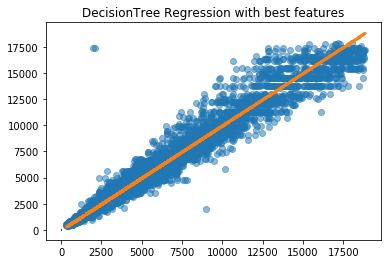

In [569]:
# as we can see color, clarity, shape and carat
best_features = ['color','clarity','shape','carat']
best_X = transformed_df[best_features]

# split data to train and test 
best_X_train, best_X_test, best_y_train, best_y_test = train_test_split(best_X, y, random_state=ran_state)


drreg = DecisionTreeRegressor(max_depth=9, random_state=ran_state, min_samples_leaf = min_sample_leaf)

#Fit the model with data (train model)
drreg.fit(best_X_train, best_y_train)
# Predict the response for a new observation.
y_pred = drreg.predict(best_X_test)

# evaluation the model 
evaluation_metrics(names[4], best_y_test, y_pred)

# visualize model predection
visualize_model_predection(names[4], best_y_test, y_pred)

The error rate is increased a little with reduce the number of features

### Modeling with Random Forest Regressor

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
RandomForest Regression
MAE  : 778.60 
MSE  : 1813330.95 
RMSE : 1346.60 
R2   : 0.88 



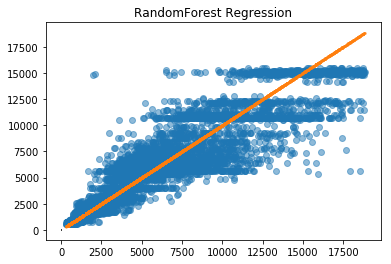

In [570]:
rfegr = RandomForestRegressor(max_depth=5, random_state=ran_state)
print(rfegr)
# split data to train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=ran_state)

#Fit the model with data (train model)
rfegr.fit(X_train, y_train)
# Predict the response for a new observation.
y_pred = rfegr.predict(X_test)

# evaluation the model 
evaluation_metrics(names[5], y_test, y_pred)

# visualize model predection
visualize_model_predection(names[5], best_y_test, y_pred)

### modeling with AdaBoost Regressor

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')
AdaBoost Regression with Linear Regression
MAE  : 997.78 
MSE  : 2262983.27 
RMSE : 1504.32 
R2   : 0.86 



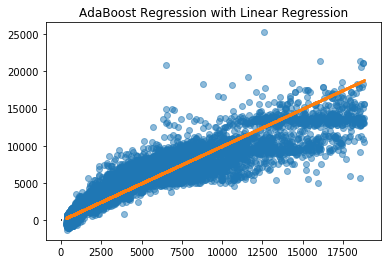

AdaBoost Regression with DecisionTree
MAE  : 942.32 
MSE  : 2428610.47 
RMSE : 1558.40 
R2   : 0.85 



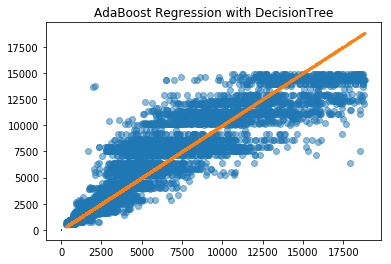

AdaBoost Regression with RandomForest
MAE  : 915.18 
MSE  : 2325877.28 
RMSE : 1525.08 
R2   : 0.85 



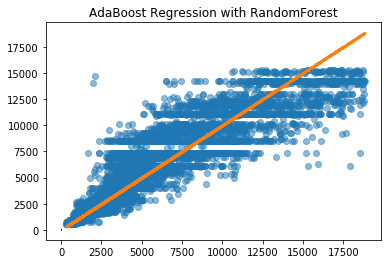

In [571]:
'''
now we'll try AdaBoostRegressor with three models, let's start with LinearRegression
'''

abreg = AdaBoostRegressor(LinearRegression(), random_state=ran_state, n_estimators=100)

print(drreg)

# split data to train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=ran_state)

#Fit the model with data (train model)
abreg.fit(X_train, y_train)
# Predict the response for a new observation.
y_pred = abreg.predict(X_test)

# evaluation the model 
evaluation_metrics(names[6], y_test, y_pred)

# visualize model predection
visualize_model_predection(names[6], y_test, y_pred)

'''
now let's try DecisionTreeRegressor
'''

abreg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5, random_state=ran_state, min_samples_leaf = 5),n_estimators=100, random_state=ran_state)

#Fit the model with data (train model)
abreg.fit(X_train, y_train)
# Predict the response for a new observation.
y_pred = abreg.predict(X_test)

# evaluation the model 
evaluation_metrics(names[7], y_test, y_pred)

# visualize model predection
visualize_model_predection(names[7], y_test, y_pred)

'''
finally let's try RandomForestRegressor
'''

abreg = AdaBoostRegressor(RandomForestRegressor(max_depth=5, random_state=ran_state),n_estimators=100, random_state=ran_state)

#Fit the model with data (train model)
abreg.fit(X_train, y_train)
# Predict the response for a new observation.
y_pred = abreg.predict(X_test)

# evaluation the model 
evaluation_metrics(names[8], y_test, y_pred)

# visualize model predection
visualize_model_predection(names[8], y_test, y_pred)

### modling with Random sample consensus

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100, min_samples=7,
        random_state=42, residual_metric=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)
Random sample consensus
MAE  : 927.65 
MSE  : 2510475.48 
RMSE : 1584.45 
R2   : 0.84 



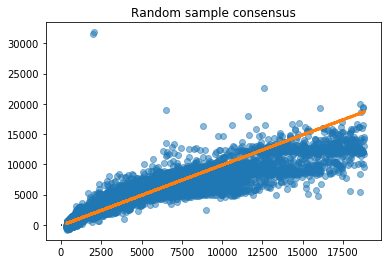

In [572]:
# Robustly fit linear model with RANSAC algorithm
ransac = RANSACRegressor(random_state=42, min_samples=7)

print(ransac)
# split data to train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Fit the model with data (train model)
ransac.fit(X_train, y_train)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict the response for a new observation.
y_pred = ransac.predict(X_test)

# evaluation the model 
evaluation_metrics(names[9], y_test, y_pred)

# visualize model predection
visualize_model_predection(names[9], y_test, y_pred)

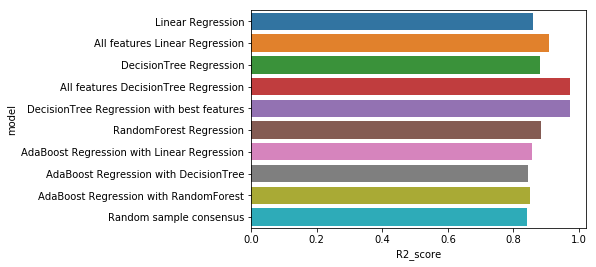

In [573]:
R2_comparison = pd.DataFrame(data={'model': names, 'R2_score': R2_list})
sns.barplot(x='R2_score' , y='model' , data=R2_comparison)